# Using physics informed neural networks (PINNs) to solve parabolic PDEs

## Example: 2D PDE 

To illustrate the PINN approach we consider the one-dimensional Burgers equation on the spatial domain x, y

$$
\begin{aligned}
    \partial_t u = (01/17\pi) ( \partial_{yy} + \partial_{xx}) , \quad &&\quad (x,y) \in (0,4] \times (0,4),\\
   u(0,x, y) &= \sin(4\pi \, x)\sin(4\pi \, y)  \\             
   u(t, x,y) = \exp(-t)\sin(4\pi \, x)\sin(4\pi \, y)                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

This PDE arises in various disciplines such as traffic flow, fluid mechanics and gas dynamics, and can be derived from the Navier-Stokes equations.

### 1. Import necessary packages and set problem specific data
optimize the Best regularization strength


In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = 1 / (17 * pi)

# Define initial condition
def fun_u_0(x, y):
    return tf.sin(4 * pi * x) * tf.sin(pi * y)

# Define boundary condition
def fun_u_b(t, x, y):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, y, u, u_t, u_x, u_y, u_xx, u_yy):
    return u_t - viscosity * (u_xx + u_yy)

# Set number of data points
N_0 = 100
N_b = 100
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 4.
ymin = 0.
ymax = 4.

# Lower bounds for 3D
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
# Upper bounds for 3D
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_0, 1), lb[2], ub[2], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0, y_0], axis=1)
# Evaluate initial condition at x_0 and y_0
u_0 = fun_u_0(x_0, y_0)

# Boundary data
t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)
y_b = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b, y_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r, 1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([t_r, x_r, y_r], axis=1)

# Convert X_r to a NumPy array
X_r_np = X_r.numpy()

# Split the dataset into training, validation, and test sets
X_train_val, X_test, _, _ = train_test_split(X_r_np, X_r_np, test_size=0.2, random_state=42)
X_train, X_val, _, _ = train_test_split(X_train_val, X_train_val, test_size=0.2, random_state=42)

def init_model(num_hidden_layers=8, num_neurons_per_layer=50, l2_reg=0.01):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(3))
    
    # Scaling layer
    model.add(tf.keras.layers.Lambda(
                lambda x: 2.0*(x - tf.reshape(lb, (1,3)))/(tf.reshape(ub, (1,3)) - tf.reshape(lb, (1,3))) - 1.0))
    
    # Add hidden layers with L2 regularization 'tanh'
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                         activation=tf.keras.activations.get('relu'),
                                         kernel_initializer='glorot_normal',
                                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))
    
    return model

def get_r(model, X_r):
    with tf.GradientTape(persistent=True) as tape:
        t, x, y = X_r[:, 0:1], X_r[:, 1:2], X_r[:, 2:3]
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)
        u = model(tf.stack([t[:, 0], x[:, 0], y[:, 0]], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)   
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
    u_t = tape.gradient(u, t)

    del tape

    return fun_r(t, x, y, u, u_t, u_x, u_y, u_xx, u_yy)

def compute_loss(model, X_r, X_data, u_data):
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    loss = phi_r
    
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

def get_grad(model, X_r, X_data, u_data):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

def train_with_regularization_strengths(regularization_strengths, X_train, u_train, X_val, u_val):
    best_model = None
    best_loss = float('inf')
    best_reg_strength = None
    
    for reg_strength in regularization_strengths:
        # Initialize model with current regularization strength
        model = init_model(l2_reg=reg_strength)
        
        # Compile the model
        model.compile(optimizer='adam', loss='mse')
        
        # Train the model
        history = model.fit(X_train, u_train, validation_data=(X_val, u_val), epochs=10, batch_size=32, verbose=0)
        
        # Evaluate model on validation set
        val_loss = model.evaluate(X_val, u_val)
        
        # Update best model and regularization strength if current model performs better
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_reg_strength = reg_strength
    
    return best_model, best_reg_strength

# Evaluate initial condition at x_0 and y_0 for the training set
u_train_0 = fun_u_0(X_train[:, 1], X_train[:, 2])

# Evaluate boundary condition at (t_b, x_b) for the training set
u_train_b = fun_u_b(X_train[:, 0], X_train[:, 1], X_train[:, 2])

# Evaluate initial condition at x_0 and y_0 for the validation set
u_val_0 = fun_u_0(X_val[:, 1], X_val[:, 2])

# Evaluate boundary condition at (t_b, x_b) for the validation set
u_val_b = fun_u_b(X_val[:, 0], X_val[:, 1], X_val[:, 2])

# Evaluate initial condition at x_0 and y_0 for the test set
u_test_0 = fun_u_0(X_test[:, 1], X_test[:, 2])

# Evaluate boundary condition at (t_b, x_b) for the test set
u_test_b = fun_u_b(X_test[:, 0], X_test[:, 1], X_test[:, 2])

# Combine initial and boundary conditions for training, validation, and test sets
u_train = [u_train_0, u_train_b]
u_val = [u_val_0, u_val_b]
u_test = [u_test_0, u_test_b]

# Define a range of regularization strengths to try
regularization_strengths = [0.001, 0.01, 0.1, 1.0]

# Train models with different regularization strengths and select the best one
best_model, best_reg_strength = train_with_regularization_strengths(regularization_strengths, X_train, u_train, X_val, u_val)

# Print the best regularization strength
print("Best regularization strength:", best_reg_strength)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(X_test, u_test)
print("Test loss:", test_loss)






50/50 [==============================] - 0s 4ms/step - loss: 0.2506
Best regularization strength: 0.01
63/63 [==============================] - 1s 7ms/step - loss: 0.2627
Test loss: 0.2627025544643402


In [25]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = 1/(17*pi)

# Define the exact solution function
def exact_solution(x, y, t):
    return tf.exp(-t) * tf.sin(4 * np.pi * x) * tf.sin(np.pi * y)

# Define initial condition
def fun_u_0(x, y):
    return tf.sin(4*pi * x)*tf.sin(pi*y)

# Define boundary condition
def fun_u_b(t, x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, y, u, u_t, u_x, u_y, u_xx, u_yy):
    return u_t - viscosity * (u_xx + u_yy)

### 2. Generate a set of collocation points

We choose training data of size $N_0 = N_b =50$ and $N_f=10000$.

In [3]:
# Set number of data points
N_0 = 100
N_b = 100
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 4.
ymin = 0.
ymax = 4.

# Lower bounds for 3D
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
# Upper bounds for 3D
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_0,1), lb[2], ub[2], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0, y_0], axis=1)
# Evaluate initial condition at x_0 and y_0
u_0 = fun_u_0(x_0, y_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_b = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b, y_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([t_r, x_r, y_r], axis=1)


# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

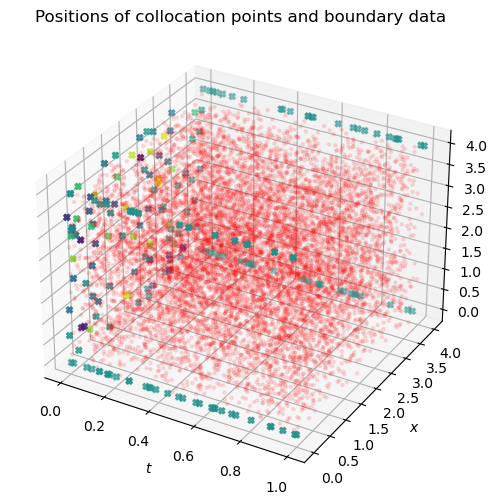

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import the 3D plotting module

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d') # Create a 3D subplot

# Plot t_0, x_0, and y_0 as the x, y, and z coordinates, and use u_0 as the color
ax.scatter(t_0, x_0, y_0, c=u_0, marker='X', vmin=-1, vmax=1)
# Plot t_b, x_b, and y_b as the x, y, and z coordinates, and use u_b as the color
ax.scatter(t_b, x_b, y_b, c=u_b, marker='X', vmin=-1, vmax=1)
# Plot t_r, x_r, and y_r as the x, y, and z coordinates, and use 'r' as the color
ax.scatter(t_r, x_r, y_r, c='r', marker='.', alpha=0.1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$y$') # Add a z-axis label

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

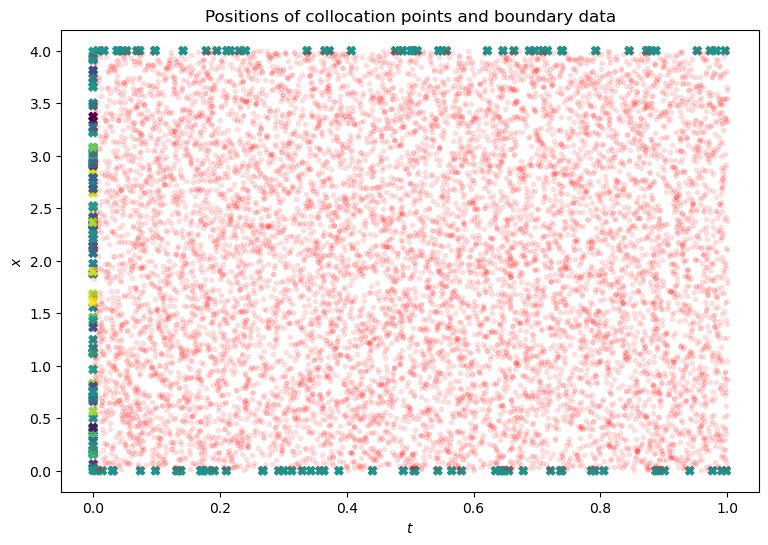

In [5]:
import matplotlib.pyplot as plt

# Create a 2D subplot
fig, ax = plt.subplots(figsize=(9, 6))

# Plot t_0, x_0, and y_0 as the x, y, and z coordinates, and use u_0 as the color
ax.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
# Plot t_b, x_b, and y_b as the x, y, and z coordinates, and use u_b as the color
ax.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
# Plot t_r, x_r, and y_r as the x, y, and z coordinates, and use 'r' as the color
ax.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
plt.show()


### 3. Set up network architecture


In [6]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=50, l2_reg=.5):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(3))
    
    # Scaling layer
    model.add(tf.keras.layers.Lambda(
                lambda x: 2.0*(x - tf.reshape(lb, (1,3)))/(tf.reshape(ub, (1,3)) - tf.reshape(lb, (1,3))) - 1.0))
    
    # Add hidden layers with L2 regularization 'relu'
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                         activation=tf.keras.activations.get('relu'),
                                         kernel_initializer='glorot_normal',
                                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))
    
    return model


### 4. Define routines to determine loss and gradient


In [7]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]


        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)


        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)   
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
    u_t = tape.gradient(u, t)

    del tape

    return fun_r(t, x, y, u, u_t, u_x, u_y, u_xx, u_yy)

The next function computes the loss for our model


In [8]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [9]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### 5. Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

In [10]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)


Train the model for $N=5000$ epochs.

In [11]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data) # get_grad function should be modified for 2D input
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


It 00000: loss = 2.16599360e-01
It 00050: loss = 1.71572164e-01
It 00100: loss = 1.19498059e-01
It 00150: loss = 8.53787959e-02
It 00200: loss = 4.37453985e-02
It 00250: loss = 3.03952098e-02
It 00300: loss = 2.05888264e-02
It 00350: loss = 2.23168433e-02
It 00400: loss = 9.32888873e-03
It 00450: loss = 9.76662412e-02
It 00500: loss = 4.82844710e-02
It 00550: loss = 5.40717915e-02
It 00600: loss = 2.52681561e-02
It 00650: loss = 6.92214351e-03
It 00700: loss = 3.17403395e-03
It 00750: loss = 2.06246995e-03
It 00800: loss = 2.91001424e-03
It 00850: loss = 7.11309782e-04
It 00900: loss = 4.67212230e-04
It 00950: loss = 5.62055095e-04
It 01000: loss = 2.26744125e-03
It 01050: loss = 1.57783463e-04
It 01100: loss = 1.19957069e-04
It 01150: loss = 9.95843948e-05
It 01200: loss = 8.36455365e-05
It 01250: loss = 7.20755997e-05
It 01300: loss = 6.33148156e-05
It 01350: loss = 5.47220479e-05
It 01400: loss = 4.89585946e-05
It 01450: loss = 4.37343842e-05
It 01500: loss = 3.99162018e-05
It 01550

313/313 [==============================] - 1s 3ms/step


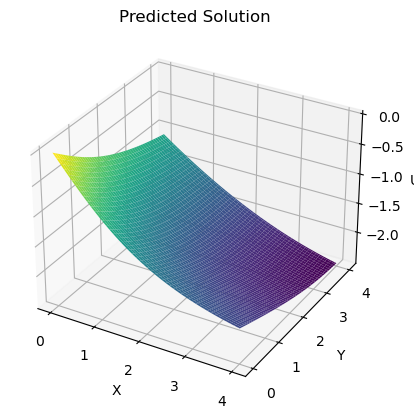

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate meshgrid for x, y coordinates
x_vals = np.linspace(xmin, xmax, 100)
y_vals = np.linspace(ymin, ymax, 100)
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)

# Flatten the meshgrid to feed into the model
t_mesh = np.ones_like(x_mesh) * tmin
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
t_flat = t_mesh.flatten()

# Combine t, x, y values into a single input array
X_plot = np.stack([t_flat, x_flat, y_flat], axis=-1)

# Predict the solution using the trained model
u_pred_plot = model.predict(X_plot).reshape(x_mesh.shape)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh, y_mesh, u_pred_plot, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title('Predicted Solution')
plt.show()